In [3]:
import pandas as pd
import numpy as np
import json
import re
import json
import csv
import re
import bs4
import requests
import time
import random

Helper Function: opening reddit Json file (from archive website)

In [4]:
def open_reddit_json(file_path):
    """
    Takes a string of a json (of scrapped Reddit data) file and turns it into a dataframe
    Inputs:
        file_path (str): the file path of the JSON file
    Returns pandas DataFrame of pertinent information
    """
    file = open(file_path, "r")

    users = []
    user_flairs = []
    titles = []
    post_texts = []
    post_dates = []
    post_flairs = []
    scores = []
    n_comments_list = []
    #links = []

    for line in file:
        post = json.loads(line)

        try:
            users.append(post.get("author", np.nan))
            user_flairs.append(post.get("author_flair_text", np.nan))
            titles.append(post.get("title", np.nan)) # will be nan for comments
            
            # post text data is located in different places if comment vs post
            post_text = post.get("selftext")
            if post_text:
                post_texts.append(post_text)
            else:
                post_texts.append(post.get("body", np.nan))
            post_dates.append(post.get("created_utc", np.nan))
            post_flairs.append(post.get("link_flair_text", np.nan))
            scores.append(post.get("score", np.nan))
            n_comments_list.append(post.get("num_comments", np.nan))
            #links.append(post.get("url", np.nan))
            
        except:
            continue

    output = pd.DataFrame({"user": users,
                           "user_flair": user_flairs,
                           "title": titles,
                           "post_text": post_texts,
                           "post_date": post_dates,
                           "post_flair": post_flairs,
                           "score": scores,
                           "n_comments": n_comments_list #,
                           # "link": links
                           })
    return output

## WEB SCRAPING

In [ ]:
### HELPERS ###
# OVERALL TASK IS TO SCRAPE REDDIT FOR POSTS AND COMMENTS

## SHOULD CHANGE THE ATTRS FUNCs TO ADD SUBREDDIT##


def get_next_page(soup):
    """
    Find the next page of a subreddit
    Input: soup (bs4 soup): an html soup of a subreddit page
    Returns str or None if it finds a next page
    """
    next_page = soup.find("span", class_="next-button")
    if next_page:
        return next_page.find("a").get("href")
    else:
        return None
    

def reddit_crawler(domain_URL, r_headers, wait_times, max_pages, csv_filename):
    """
    Crawls a reddit by page, obtaining a link for each page on subreddit
    returns a tuple of the visited_pages, visited_pages_soup, urls_to_visit
    
    OUTPUTS
    visited_pages (list) of page urls
    visited_pages_soup (list) of page soups (same len as visited_pages)
    urls_to_visit (list) of all comment urls on every page 
    
    also creates a .csv file with the link and soup for the webpage
    """
    visited_pages = []
    urls_to_visit = []
    visited_pages_soup = []
    num_pages_visited = 0
    curr_url = domain_URL # initialize curr_url as domain_URL
    min_time, max_time = wait_times
    
    # create a csv file
    with open(csv_filename, 'a', newline='', encoding='utf-8') as csvfile:
        # Create a CSV writer object
        csv_writer = csv.writer(csvfile)

        # Check if the file is empty (write header if needed)
        if csvfile.tell() == 0:
            csv_writer.writerow(["link", "soup"])
        
        # while the number of pages is less than the max
        while num_pages_visited < max_pages:
            # add current page to visited pages
            num_pages_visited += 1

            print("Pages visited:", num_pages_visited)

            # get request for webpage
            request = requests.get(curr_url, headers=r_headers)

            # give the server a break
            time.sleep(random.uniform(min_time, max_time))

            # if request is valid
            if request.status_code == 200:
                soup_page = bs4.BeautifulSoup(request.text, "html.parser")
                
                # update the CSV with this new url and page
                csv_writer.writerow([curr_url, soup_page])

                # updated visited pages soup list
                visited_pages_soup.append(soup_page)
                visited_pages.append(curr_url)

                # find all the comment links
                links_html = soup_page.find_all("a", class_ = re.compile(r"bylink comments"))
                links = [link.get("href") for link in links_html]
                # add links to visited_urls
                urls_to_visit += links

                next_page = get_next_page(soup_page)
                if next_page:
                    curr_url = next_page
                else:
                    break
            
            # if unable to get current URL request, return visited URLs
            else:
                print(f"Response {request.status_code}. Couldn't get URL: {curr_url}.")
                break
        
    return visited_pages, visited_pages_soup, urls_to_visit


def find_post_attrs(post):
    "From post, find important post attributes for a Reddit post, a list"
    if not post:
        return [None]*9
    # find the user
    try:
        user = post.find("div").get("data-author")
    except:
        user = None
    try:
        user_flair = post.find("p", class_="tagline").find("span", class_=re.compile("flair")).text
    except:
        user_flair = None

    try:
        title = post.find("a", class_=re.compile("title")).text
    except:
        title = None
    
    try:
        post_text = post.find("div", class_="md").text
    except:
        post_text = None
    
    try:
        post_date = post.find("div").find("time").get("datetime")
    except:
        post_date = None

    try:
        post_flair = post.find("p", class_=re.compile("title")).find("span", class_=re.compile("flair")).text
    except:
        post_flair = None

    try:
        score = post.find("div", class_="score unvoted").text
    except:
        score = None

    try: 
        n_comments = post.find("div").get("data-comments-count")

    except:
        n_comments = None

    try:
        link = post.find("a", class_=re.compile(r"comments")).get("href")
    except:
        link = None
    post_attrs = [user, user_flair, title, post_text, 
                  post_date, post_flair, score, n_comments, link]

    return post_attrs


def find_com_attrs(comment, link):
    if not comment:
        return [None]*9
    try:
        user = comment.find("a", class_=re.compile("author")).text
    except:
        user = None
    try:
        user_flair = comment.find("span", class_= re.compile(r"flair")).get("title")
    except:
        user_flair = None
    try:
        com_text = comment.find("div", class_="md").text
    except:
        com_text = None
    try:
        com_date = comment.find("time").get("datetime")
    except:
        com_date = None

    try:
        com_score = int(comment.find("span", class_="score unvoted").get("title", 0))
    except:    
        com_score = None

    com_attrs = [user, user_flair, None, com_text, 
                 com_date, None, com_score, None, link]
    
    return com_attrs



def reddit_scraper(page_soups, r_headers, wait_times, csv_filename, max_com):
    min_time, max_time = wait_times
    '''
    Scrape all the post and comment text for a given subreddit page, return
    all post soups
    '''

    all_post_soups = []
    
    # create CSV file
    with open(csv_filename, 'a', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        # initialize column names if blank
        if csvfile.tell() == 0:
            csv_writer.writerow(["user", "user_flair", "title", "post_text", 
                                 "post_date", "post_flair", "score", 
                                 "n_comments", "link", "is_comment"])
        
        # iterate over all webpage soups
        for page_soup in page_soups:
            site_table = page_soup.find("div", id="siteTable")
            posts = site_table.find_all("div", class_=re.compile(r"thing"))
            posts_links = [p.find("a", class_= re.compile("bylink")).get("href") for p in posts]

            for post_link in posts_links:
                time.sleep(random.uniform(min_time, max_time))
                
                request = requests.get(post_link, headers=r_headers)

                if request.status_code == 200:

                    # find the post
                    post_soup = bs4.BeautifulSoup(request.text, "html.parser")
                    post = post_soup.find("div", class_=re.compile(r"sitetable"))
                    post_attrs = find_post_attrs(post)
                    all_post_soups.append(post_soup)
                    csv_writer.writerow(post_attrs + [False])

                    # print("\t### MOVING ON TO COMMENT SECTION ###")
                    
                    # find the comment section
                    comment_section = post_soup.find("div", class_= "sitetable nestedlisting")
                    comments = comment_section.find_all("div", class_="entry unvoted")

                    for comment in comments[:max_com]:
                        com_attrs = find_com_attrs(comment, post_link)
                        
                        csv_writer.writerow(com_attrs + [True])
                    
                    # print(f"\t\t## STOPPED ##\n\t\t## MOVING TO NEXT POST ##")

                else:
                    # if we fail to get request, find the link that did it
                    print(f"!!!! FAILURE !!!!\nResponse {request.status_code}. Couldn't get URL: {post_link}.")
                    
    
    return all_post_soups


def get_data(domain_URL, r_headers, wait_times, max_pages, max_com, pages_csv, posts_csv):
    """
    Given a subreddit, find all posts and comments
    for debugging purposes, returns soups for all posts

    INPUTS
        max_pages limits the number of pages to crawl
        max_com is for limiting the number of comments per post to scrape

    ALSO 
    gets creates two CSV files one for tracking page soups, the other for the actual data

    """
    # get soup for EACH webpage in a subreddit
    _, soups, _ = reddit_crawler(domain_URL, r_headers, wait_times, max_pages, pages_csv)

    print("##### DONE CRAWLING #####\nMOVING ON TO SCRAPING FOR POSTS AND COMMENTS")

    post_soups = reddit_scraper(soups, r_headers, wait_times, posts_csv, max_com)
    
    print("##### DONE SCRAPING #####")
    
    return soups, post_soups

In [ ]:
# run once
soups = get_data("https://old.reddit.com/r/Adopted/", {"User-Agent": "Ethan K."}, (1, 2), 1000, 150, 'adopt_pages.csv', "adopt_posts.csv")
pd.Series(soups).to_csv("all_adopted_posts_soups.csv")

## DATA CLEANING

In [5]:
# create dfs from csvs
adopted = pd.read_csv("D:\\hw\\adopt-proj\\adopt_posts.csv") # now with comments
adoption_1 = pd.read_csv("D:\\hw\\adopt-proj\\adoption_posts.csv")

# drop link column
adopted.drop(columns=["link"], inplace=True)
adoption_1.drop(columns=["link"], inplace=True)

# change this to datetime instead of str
adopted['post_date'] = pd.to_datetime(adopted['post_date'])
adoption_1['post_date'] = pd.to_datetime(adoption_1['post_date'])

In [6]:
# split r/Adopted into comments and posts
adopted_comms = adopted.loc[adopted["is_comment"] == True]
adopted_comms = adopted_comms.drop(columns=["is_comment"])

adopted_posts = adopted.loc[adopted["is_comment"] == False]
adopted_posts = adopted_posts.drop(columns=["is_comment"])


# split r/Adoption into comments and posts
adoption_1_comms = adoption_1.loc[adoption_1["is_comment"] == True]
adoption_1_comms = adoption_1_comms.drop(columns=["is_comment"])

adoption_1_posts = adoption_1.loc[adoption_1["is_comment"] == False]
adoption_1_posts = adoption_1_posts.drop(columns=["is_comment"])

In [7]:
# add some supplementary data from archived source
adoption_2_posts = open_reddit_json("D:\\hw\\adopt-proj\\Adoption_submissions.json")
adoption_2_comms = open_reddit_json("D:\\hw\\adopt-proj\\Adoption_comments.json")

In [8]:
# change the values in post_date to datetime objects

adoption_2_comms['post_date'] = pd.to_datetime(adoption_2_comms['post_date'].astype(int), unit='s').dt.tz_localize("UTC")
adoption_2_posts['post_date'] = pd.to_datetime(adoption_2_posts['post_date'].astype(int), unit='s').dt.tz_localize("UTC")

In [9]:
# concat data sets
adoption_comms = pd.concat([adoption_1_comms,adoption_2_comms])
adoption_posts = pd.concat([adoption_1_posts,adoption_2_posts])

# change this one weird quirk
adoption_posts.loc[adoption_posts["score"] == "•","score"] = np.nan


# remove posts with no post text, also remove duplicates
adoption_posts = adoption_posts.dropna(subset=["user", "post_text"]).drop_duplicates()
adoption_comms = adoption_comms.dropna(subset=["user", "post_text"]).drop_duplicates()
# also do the same for r/Adopted, but this should do nothing
adopted_posts = adopted_posts.dropna(subset=["user", "post_text"]).drop_duplicates()
adopted_comms = adopted_comms.dropna(subset=["user", "post_text"]).drop_duplicates()

In [10]:
# find posts where they have been removed or deleted
pattern = re.compile(r"^\[*\(*(removed|deleted)")
# exclude such posts from the datasets
adoption_posts = adoption_posts.loc[~adoption_posts["post_text"].astype(str).apply(lambda x: True if pattern.match(x) else False)]
adoption_comms = adoption_comms.loc[~adoption_comms["post_text"].astype(str).apply(lambda x: True if pattern.match(x) else False)]
adopted_posts = adopted_posts.loc[~adopted_posts["post_text"].astype(str).apply(lambda x: True if pattern.match(x) else False)]
adopted_comms = adopted_comms.loc[~adopted_comms["post_text"].astype(str).apply(lambda x: True if pattern.match(x) else False)]

In [11]:
# remove posts that are just empty strings
adoption_posts = adoption_posts[adoption_posts["post_text"] != ""].reset_index(drop=True)
adoption_comms = adoption_comms[adoption_comms["post_text"] != ""].reset_index(drop=True)
# should not really change much for r/Adopted data I scraped myself
adopted_posts = adopted_posts[adopted_posts["post_text"] != ""].reset_index(drop=True)
adopted_comms = adopted_comms[adopted_comms["post_text"] != ""].reset_index(drop=True)

In [12]:
# Find adoptees by user flair tags
pattern = re.compile(r"((?<!of an )(adoptee(?!s)\b|adopted|\bTRA\b|\bKAD\b))|(?<!of a )(adoptee(?!s)\b|adopted(?!kid)|adopted(?!child)|\bTRA\b|\bKAD\b)", re.IGNORECASE)
adoption_posts["is_adoptee"] = adoption_posts["user_flair"].astype(str).apply(lambda x: True if pattern.match(x) else False)
adoption_comms["is_adoptee"] = adoption_comms["user_flair"].astype(str).apply(lambda x: True if pattern.match(x) else False)
adopted_posts["is_adoptee"] = adopted_posts["user_flair"].astype(str).apply(lambda x: True if pattern.match(x) else False)
adopted_comms["is_adoptee"] = adopted_comms["user_flair"].astype(str).apply(lambda x: True if pattern.match(x) else False)

In [13]:
# # save as csv
# adoption_posts.to_csv("adoption_posts_df.csv",index=False)
# adoption_comms.to_csv("adoption_comms_df.csv",index=False)
# adopted_posts.to_csv("adopted_posts_df.csv",index=False)
# adopted_comms.to_csv("adopted_comms_df.csv",index=False)

In [14]:
# spacy is a good module to use for textual analyses
import spacy
nlp = spacy.load("en_core_web_sm")


# we will require this function later
# function from HW2 of Content Analysis


def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized


def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])

    doc = nlp(word_list.lower())

    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [15]:
adp_df = adopted_posts
adc_df = adopted_comms
anp_df = adoption_posts
anc_df = adoption_comms

In [16]:
# #### DON'T RUN AGAIN ####
# # for this task, merge them

# # get the dataframes


# all_df = pd.concat([adp_df, adc_df, anp_df, anc_df]).reset_index(drop=True)


# # takes around 66 minutes to run
# all_df["tokenized_text"] = all_df.loc[:,'post_text'].apply(lambda x: word_tokenize(x))
# all_df['word_counts'] = all_df.loc[:,'tokenized_text'].apply(lambda x: len(x))
# # takes around 61 minutes to run
# all_df['normalized_tokens'] = all_df['tokenized_text'].apply(lambda x: normalizeTokens(x))
# all_df['normalized_tokens_count'] = all_df['normalized_tokens'].apply(lambda x: len(x))



New stuff 2/12: fixing issues with labels being wrong

In [23]:
adopted_i = len(adp_df) + len(adc_df)

In [66]:
all_df = pd.read_pickle("all_df.pkl")

In [64]:
# add labels for subreddit
all_df['sub'] = 'r/Adoption'  # Initialize the column with 'r/Adoption'
all_df.loc[:adopted_i, 'sub'] = 'r/Adopted'

In [234]:
uniques = all_df.user_flair.unique()
# for i in uniques:
#     print(i)
len(uniques)

470

In [97]:
# with open('D:\\hw\\adopt-proj\\labels.txt', 'r') as file:
#     # Read the lines of the file and store them in a list
#     labels = file.readlines()

# # Strip newline characters from each line and create a list
# labels = [line.strip() for line in labels]

In [47]:
# pattern = re.compile(r"((?<!of an )(adoptee(?!s)\b|adopted|\bTRA\b|\bKAD\b))|(?<!of a )(adoptee(?!s)\b|adopted(?!kid)|adopted(?!child)|\bTRA\b|\bKAD\b)", re.IGNORECASE)
# all_df["is_adoptee"] = all_df["user_flair"].astype(str).apply(lambda x: True if pattern.match(x) else False)

In [214]:
adoptee_labels = ['Adoptee (UK)',
 'Domestic Infant Adoptee',
 'Transracial Adoptee',
 'Adoptee',
 'International Adoptee',
 'Baby Scoop Era Adoptee',
 'Adult Adoptee (DIA)',
 'Mentally ill adopted teen',
 'adopted at birth',
 'Failed Adoptee',
 'Reunited Adoptee',
 'Adoptee ❤️',
 'Adopted at 2 from Ukraine to the USA',
 'Teen Adoptee, open adoption',
 'Adoptee and Birth Parent',
 'in adoption limbo ...',
 'adopted family divorcee, adopted by birth mom',
 'adoptee in reunion',
 'adoptee',
 'Korean-American  Adoptee',
 'Adoptee with 6 parents',
 'Happily reunited adoptee',
 '32/M/adoptee/in-reunion',
 'Adopted @ 6yo',
 '(Adoptee, 1973)',
 'Adoptee, looking',
 'Adoptee/Step Dad',
 'Adoptee and Birthmother',
 'Adoptee recently reunited',
 'Adopted',
 'Adoptee Moderator',
 'Adopted, trad/closed, Ohio',
 'Adoptee, Foster Mama',
 'Adult Adoptee',
 'Closed At-Birth Adoptee',
 'Foster Adoptee',
 'Reunited adoptee',
 'adoptee, closed adoption, seeking reunification',
 'Chinese Adoptee',
 'late-discovery-adoptee',
 'Korean Adoptee, Married, CF',
 'Adopted at birth',
 'Russian - Kiwi Adoptee',
 'Not Quite Adopted',
 'adopted',
 'INFP: The Dreamer',
 'Transracial adoptee',
 'Closed Adoption Adoptee',
 'Adoptee Recently Reuinited',
 'transracial &amp; transnational adoptee',
 'Transracial US Domestic Adult Adoptee',
 'Korean Adoptee',
 'LDA, FFY, Indigenous adoptee',
 'Adoptee',
 'Chinese Adoptee in Canada (23F)',
 '1970 Closed Adoption Adoptee',
 'adopted from China at 12mo',
 'Open Adoption Adoptee',
 'LDA, FFY, Indigenous adoptee',
 'Russian Adoptee',
 'International adoptive mom of two (Vietnam)',
 'Russian adoptee',
 'neo city 💚',
 'Pre-Adoptive / Prospective Parents (PAP)',
 'Teen Adoptee',
 'Live, Love, Learn',
 'transracial adoptee',
 'adoptee // 23',
 'TRA/ICA/KAD (minor)',
 'Adult Adoptee🤍',
 'Adult adoptee, hoping to adopt',
 'Punjabi-Canto transracial adoptee',
 'Asian Adoptee',
 'adoptee',
 'Adoptee From USA',
 'recently found my bio fam :)',
 'non paternal event / LDA',
 'Adopted',
 'Late Disclosure Adoptee, Future Adoptive Parent',
 'Private Infant Adoptee - 24F',
 'adopted at infancy',
 '(Lifelong Open) Adoptee',
 'Adoptee (🇨🇳 —&gt; 🇫🇷)',
 'Late Discovery Adoptee (LDA)',
 'International Asian TRA',
 "int'l adoptee",
 'TRA',
 'Teen Adoptee, open adoption',
 'Adoptee &amp; Genealogical Detective!',
 'adult adoptee',
 'multiracial // transracial adoptee | prioritizing adoptee voices',
 'step adoptee',
 'half-adopted, hap',
 'Adoptee @ 106 Days &amp; Genealogical Detective!',
 'Adoptee; Confused as Hell',
 'Second-generation adoptee',
 'TRA/ICA',
 'Adoptee (domestic infant adoption)',
 'Closed Adoption Infant Adoptee',
 'UK Adoptee',
 'Closed domestic (US) infant adoptee in reunion',
 'adopted & hap',
 'Adopted in the late 60’s',
 'Transracial Adult Adoptee',
 'Adoptee @ 106 Days & Genealogical Detective',
 'Adoptee & AP',
 'adoptee & parent',
 'Domestic Infant Adoptee',
 '🇷🇺',
 'Closed domestic (US) adult adoptee in reunion',
 'Black adult invisible adoptee',
 'Chinese American Adoptee',
 'Adoptee (US)',
 '60s scoop reunited',
 'transracial adoptee',
 'DIA in Reunion',
 'Adoptee of Closed Adoption',
 'Private Infant Adoptee - 25F',
 'transracial closed adoptee',
 "adoptee '87",
 'TRA / Chinese adoptee',
 'Late discovery adoptee, 26 yrs. Met bio families.',
 'Adult DIA Adoptee',
 'late age adoptee',
 'adoptee & birthparent',
 'victim of domestic & state violence via transracial adoption',
 'Adoptee, Birthmother, & Parent',
 'Domestic Adoptee 1988',
 'BIA adoptee',
 'foster care (2007-2010) / adopted (2010)',
 'adoptee open adoption',
 'Adoptee and Psychologist',
 'Who am I?',
 'domestic infant(ish) adoptee',
 'Adoptee of Failed Adoption',
 'Adoptee and  Birthmother',
 'adoptee + adoptive parent',
 'Reunited Adoptee &amp; Adoptee Rights Activist',
 'Adoptee, Adoptive Parent',
 'adoptee 3.11.87',
 'Adopted Faery',
 'Adopted Kid',
 'Adopted from Bangladesh',
 'KAD wutup!',
 'Adopted: birth.  Found bio siblings: age 20.',
 'Adoptee, 29F',
 'Closed adoption: birth. Found bio siblings: age 20.',
 'Adoptee /  Adoptive Parent',
 'Adoptee Found Birth Family',
 'adoptee; foster parent',
 'Adopted/Plans to adopt',
 'Transracial Adoptee (KAD)',
 'Birthmom+Adoptee',
 'Adopted at Birth | Found Birthfamily',
 'Foster Parent/Adoptee',
 'Moderator, adoptee',
 'Two moms, two dads, lucky reunited adoptee',
 'adoptee / plans to adopt',
 'Adopted 1993 | Reunited 2017',
 'Adopted as a baby',
 'Chinese adoptee',
 'Adoptee (International)',
 'Adoptee, Birthmother, Adoptive parent',
 'Adoptee, Activist',
 'Adopted from Russia',
 'Adoptee - Found birth family',
 'Punjabi-Canto interracial adoptee',
 'Korean adoptee',
 'Transracial Adoptee &amp; Birth Mother',
 'Trans-Racial Adoptee | PAP | Anti-Natalist',
 'Kazakh adoptee',
 'late-discovery adoptee, ex-ward',
 'LDA, ex-ward, Indigenous post-ICWA adoptee',
 'Adult Adoptee/Found Bio Parents - Ohio 1986 Prive Adoption',
 'Transnational Adoptee from Birth',
 "author, the adoptee's guide to dna testing (book)",
 'LDA, ex-ward, Indigenous adoptee',
 'Adoptee, Only Child',
 'Closed Adoption Adoptee Reunited',
 'late-discovery-adoptee, ex-foster-kid',
 'Adoptee &amp; Adopter',
 'Taiwanese Adoptee',
 'r/Adoptee Moderator',
 'Closed DIA',
 'Adopted aged four',
 'Adult adoptee',
 'Adopted @11days - reunited @ 27y/o',
 'TRA/IA/LDA/AP/FP',
 'intrafamily adoptee, school aged adoptee',
 'Adoptee/closed Birthmom/open',
 'china adoptee',
 'Childhood adoptee/Birthmother to now adult',
 'First Nations Adoptee',
 'Chinese Transracial Adoptee',
 'second-generation adoptee',
 'International adoptee',
 'International Transracial Adoptee',
 'From Russia with Love?',
 'FFY/Adoptee',
 'TransAdoptedKid',
 'adoptee and 23 ✌️',
 'Adopted Person',
 'adoptee/former foster kid',
 'Pre-Adoptive Parent | Adopted',
 'adoptee // 24',
 'victim of domestic &amp; state violence via transracial adoption',
 'cambodian adoptee',
 'Adult Adoptee Found BioFamily',
 'Birth adoptee reunited w/BM &amp; Half-Siblings',
 'Adoptee, may consider adoption in the future',
 'Adopted from China',
 'Adopted at birth',
 'Transracial Indigenous Adoptee',
 'Adoptee from birth',
 'Adopted Chinese',
 'reunited adoptee',
 'TRA/ICA/KAD',
 'Adopted as an Infant',
 'Transracial/international Adoptee',
 'open adoptee from birth',
 'Half-adopted',
 'adoptee &amp; parent',
 'Adopted at Birth',
 'domestic adoptee at birth | found birthparents']
adoptee_labels = [re.escape(i) for i in adoptee_labels]
adoptee_labels = "|".join(adoptee_labels)

non_adoptee_labels = ['Former Foster Youth',
 'Future AP',
 'Bio Parent',
 'Birthfather',
 'Prospective Adoptive Parent',
 'Birth Mother - Open Adoption',
 'Mom through private domestic open transracial adoption',
 'Reunited mother, former legal guardian, NPE',
 'Reunited Mom, Foster Mom, L8 Dscvry Adoptee-paternal side',
 'Reunited Birthparent.',
 'Current Intl AP, Past Temp Foster Child',
 'Birth Mom',
 'AP, former FP, ASis',
 'Birthmother.',
 'birthmother',
 'Birthmother 6/23/12',
 '14 adoptions in my family',
 'Hopeful AP',
 'Adoptive parent',
 'birth parent',
 'Adoptive Parent',
 'Birthmother, 2002',
 'Biological Father - searching',
 'looking to adopt',
 'adoptive father',
 'Father of sibling group of 3',
 'birth mom',
 'Hopeful adopter',
 'Adopting in Arkansas',
 'Birthmom',
 'Hoping to adopt',
 'Looking into Adopting',
 'caseyalexanderblog.wordpress.com',
 'naturalmother_8-14-01',
 'Someday-adopter',
 'Potential Birthmother',
 'waiting prospective AP',
 'future AP',
 'foster-to-adopt aunt/mom',
 'Adoptive Dad',
 'BP',
 'I Fostered &amp; Then Adopted',
 'Adoptive Parent/Orphanage Supervisor',
 'Adoptive Parent (fostadopt)',
 'hypervigilant.org',
 'Possible AP',
 'fost-adopt parent',
 'pre-adoptive parent',
 'Birth Parent',
 'Birth Father &amp; /r/OpenAdoption Owner',
 'RecentBM',
 'Birthmother',
 'Adoptive/Foster Mom',
 'Adoptive Father',
 'foster adopt',
 'Adopted Family Member?',
 'Prospective adoptive parent',
 'Pre-fostering | prospective foster',
 'First Mother',
 'Bio of 2, Adoptive of 2',
 'Sister adopted in x2, aunt adopted out x1',
 'Hopeful APs',
 'Researching foster/adoptive parenting',
 'future FAD parent',
 'Birthmother, Open Adoption',
 'Adopting!',
 'Adoptive Parent - Intercountry + Fostered',
 'Post-Adoptions social worker', 
 'Adoptive Parent, Data Analyst',
 'Bio sis',
 'Adoptive/Foster Parent',
 'ex-foster-kid',
 'kinship adoptive parent / foster parent',
 'Birthmother 2/13/2002',
 'Transracial Adoptive Parent/Foster Parent',
 'parent of adopted kids',
 'Adoptive Mama',
 'AP',
 'Birthfather 10/21/1986',
 'Interested, but no plans',
 'Planning to Adopt in the Future',
 'Future Foster/Adoptive Parent',
 'Birth mother',
 'Foster parent/Adoptive parent',
 'Firstmom',
 'Son, 12.. BirthMom',
 'Father of 3, all adopted',
 'kinship/foster parent',
 'Momma',
 '23F- Future Adopter',
 'Reunited Mom',
 'Foster parent',
 'Adoptive father',
 'firstmother 2001',
 'Adoptive mom of 3',
 'Adoptive Dad of 3, soon 6',
 'bio sibling',
 '5 failed matches, currently in #6 due winter 2016',
 'Soon to be mom',
 'Potential Adoptive Parent',
 'foster/pre-adoptive parent',
 'Intl Adoptive Parent',
 'In Progress',
 'Wanting to Adopt',
 'Birth Father',
 '2 failed matches, still hoping',
 'adoptive mom',
 '3 failed matches, still hoping',
 'Someday-adopter, adoptive sister',
 'Future adoptive parent',
 'Matched with an expectant mom due in winter 2015',
 'Adoptive Parents',
 'Birthmother (Open Adoption)',
 'AParent to teen',
 'Son, 8.. BirthMom',
 'Future Parent',
 'considering adopting',
 'Looking to adopt (Ontario)',
 'Homestudied and waiting',
 'Adopting thru Foster Care',
 'sister of adoptee; future adoptive parent',
 'Adoptive sister',
 'Adoptive Dad of 3, soon 5',
 'Adoption Researcher',
 'was a foster parent',
 'Parent',
 'hoping to adopt',
 'Father of 4 adopted sons',
 'birthmom 2010, beautiful boy!',
 'would like to adopt',
 'Foster-to-Adopt',
 'Birthmom 7/31/1992',
 'potential adoptive father',
 '-25-groomer-wannabe adopter',
 'Luckiest',
 'Homestudied hopeful adopter',
 '3 adopted',
 'sister of an adoptee',
 'parent of several adopted kids',
 'Birthmother, Daughter, Sister, Aunt, and Wife',
 'adoptDad',
 '(b-mom, 1976)',
 'Birthmom 3/15/98',
 'Adoption Specialist',
 'Fost-Adoptive parent of 3',
 'HAP',
 'Adoptive mom - open kinship',
 'sister of adoptee; hopeful future AP',
 'Birth Mom',
 'haole, male, father to a daughter who was adopted, but not by me',
 'may adopt in the future',
 'LGBT adoptive parent &amp; daughter of adoptee',
 'Adoptive Parent of Older Teen',
 'prospective/pre-adoptive parent',
 'Birthmom 2017',
 'Birthmom 12/18/18',
 'Furture adoptive mom, by choice.',
 'Adoptive Parent x3',
 'Future Father',
 'Adoptive Parent &amp; Spouse to Adoptee',
 'Adoptive Mama',
 'prospective adoptive parent',
 'Bio-Sis, Hopefully Future Adoptive Parent',
 'Kinship AP',
 'NY, Adoptive Parent, Permanency Specialist',
 'Prospective AP',
 'FFY - AP',
 'Perspective adoptive parent',
 'Adoptive Parent (International/Transracial)',
 'Birth Mum.',
 'Former foster kid. Almost-adopted more than once.',
 'Adoptive Mother | Australia',
 'Hoping to Adopt',
 'Parent by Adoption',
 'Researching PAP',
 'One Adopted (Kinship), Seven Bio',
 'Adoptive Parent (Kinship Via Husband)',
 'foster mom',
 'Younger Bio Sibling',
 'Foster/Adoptive parent',
 'AdoptiveParent',
 'Adult Child of Adoptee',
 'AP of teen',
 'adoptive parent',
 'Birth mom, 2017',
 'Birth Mum of two - adopted by force.',
 'buried under a pile of children',
 'Adoptive mom',
 'Daughter of 2 adoptees',
 'Adoptive Mother',
 'Reunited Birthparent.',
 'Foster Parent',
 'Adoptive Dad of 5 (2 sib grps from foster care)',
 'Birthmother 12/13/2002',
 'PAP',
 'Prospective Parent',
 'AP, former FP, ASis',
 'biological parent',
 'Birth Parent in StepParent Adoption',
 'Open Adoption Birth Father &amp; /r/OpenAdoption Owner',
 'Foster Parent, Child Welfare Public Health Professional',
 'Have adopted-in siblings; searching for adopted-out sister',
 'Pre-Placement Parent',
 '16|05.20.2020|Adoption',
 'Prep-Adoptive',
 'daughter of an adoptee',
 'Adoptive Mom',
 'reunited mom, lgl grdian, NPE',
 'Birth Mother',
 'NPE',
 'Bio-Sib of an adoptee',
 'Potential Foster Parent',
 'Foster / Adoptive Parent',
 'Foster Mom',
 'mother was adopted',
 'Stepmum to long lost adoptee / reunited',
 'daughter of an adoptee. future adoptive parent.',
 'Birthparent / Baby Girl due 12/28 :)',
 'Prospective Adoptive Mother',
 'Reunited Birthmom',
 'Foster/Adoptive Parent',
 'Hopeful Adoptive Parent',
 'foster parent',
 'Prospective Adoptive Parent',
 'hopeful foster parent',
 '15 adoptions in my family',
 'Reunited Birthparent.',
 'Reunited Bio Mom',
 'Adoptive Parent &amp; Adoptee’s spouse',
]
non_adoptee_labels = [re.escape(i) for i in non_adoptee_labels]
non_adoptee_labels = "|".join(non_adoptee_labels)

In [217]:
adoptee_pattern = re.compile(r"{}".format(adoptee_labels), re.IGNORECASE)
non_adoptee_pattern = re.compile(r"{}".format(non_adoptee_labels), re.IGNORECASE)

def categorize_user(x):
    if adoptee_pattern.match(x):
        return 1  # Adoptee
    elif non_adoptee_pattern.match(x):
        return 0  # Non-adoptee
    else:
        return 2  # NEI

all_df["is_adoptee"] = all_df["user_flair"].astype(str).apply(categorize_user)

In [237]:
# functions from TextClassification.ipynb MACS 30100

from tqdm import tqdm
import re, string
from bs4 import BeautifulSoup

def decontracted(phrase):
    """
    Expand the contracted phrase into normal words
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase) # prime 
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase


def clean_text(df):
    """
    Clean the review texts
    """
    cleaned_post_text = []

    for post_text in tqdm(df['post_text']):
        
        # expand the contracted words
        post_text = decontracted(post_text)
        
        #remove html tags
        post_text = BeautifulSoup(post_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)
        
        #remove non-alphabetic characters
        post_text = re.sub("[^a-zA-Z]"," ", post_text)
    
        #remove url 
        post_text = re.sub(r'https?://\S+|www\.\S+', '', post_text)
        
        #Removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        post_text = post_text.translate(str.maketrans('', '', string.punctuation))
        # ''.join([char for char in movie_text_data if char not in string.punctuation])
        
        # remove emails
        post_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', post_text)
    
        cleaned_post_text.append(post_text)

    return cleaned_post_text

all_df['cleaned_post_text'] = clean_text(all_df)

  0%|          | 0/301967 [00:00<?, ?it/s]C:\Users\Ethan\AppData\Local\Temp\ipykernel_17684\814632459.py:40: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  post_text = BeautifulSoup(post_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)
  1%|          | 1944/301967 [00:00<00:58, 5126.10it/s]C:\Users\Ethan\AppData\Local\Temp\ipykernel_17684\814632459.py:40: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  post_text = BeautifulSoup(post_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)
100%|██████████| 301967/301967 [01:18<00:00, 3829.57it/s]


In [238]:
truth_df = all_df[all_df.is_adoptee < 2]

In [239]:
all_df.to_pickle("all_df.pkl")
truth_df.to_pickle("truth_df.pkl")

## Data Analysis

In [ ]:
import os
import numpy as np
import pandas as pd
import re, string

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures


from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import spacy
nlp = spacy.load("en_core_web_sm")

from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
from nltk.stem import PorterStemmer

import gensim

from tqdm import tqdm
from bs4 import BeautifulSoup

# for counting
from collections import Counter

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
## IMPORT OUR CLEANED DATA ##
truth_df = pd.read_pickle("D:\\hw\\adopt-proj\\truth_df_vect_sents.pkl")

Find our stopwords

In [ ]:
stop_words = stopwords.words('english')

#### GETTING INTO MACHINE LEARNING, VECTORIZATION, REGRESSION, ETC ####

It is important to tune the max_df, min_df parameters and possibly add more stop words. For this example, I will use a count vectorizer (bag of words) for this classification task

In [ ]:
vectorizer = CountVectorizer(lowercase=True, stop_words=stop_words, max_df=0.9, min_df=3, ngram_range=(1,1))

# convert the cleaned reviews to vectors
X = vectorizer.fit_transform(truth_df.cleaned_post_text)
y = truth_df.labels

#### Train and test splitting ####

In [ ]:
train_idx, test_idx = train_test_split(np.arange(truth_df.shape[0]), test_size=0.3, 
                                       shuffle=True, random_state=42)

X_train = X[train_idx]
y_train = y.iloc[train_idx]

X_test = X[test_idx]
y_test = y.iloc[test_idx]

print("Training data: X_train : {}, y_train : {}".format(X_train.shape, y_train.shape))
print("Testing data: X_test : {}, y_test : {}".format(X_test.shape, y_test.shape))

Training data: X_train : (38840, 17729), y_train : (38840,)
Testing data: X_test : (16647, 17729), y_test : (16647,)


## Logistic Regression ##


We can see that the logistic regression model classifies the texts to the correct label in .701 of all cases. This accuracy is still not good considering that 2/3 of the labels are nonadoptee vs adoptee.

We can see that although the accuracy is okay, this does not take into consideration the sample imbalance. We see that most of the reason accuracy is so high is because of the high number of true negatives. We see that the recall rate for adoptee posts is quite low at .394. This means that the model only finds 40% of all the posts truly written by adoptees. Furthermore the adoptee precision is .578 meaning that only a little bit more than half of the predicted adoptee posts were true adoptee posts. We can see the f1 score for adoptee posts is also quite low.

Accuracy: 0.701
adoptee Precision: 0.578
non_adoptee Precision: 0.738
adoptee Recall: 0.394
non_adoptee Recall: 0.855
adoptee f1: 0.469
non_adoptee f1: 0.792


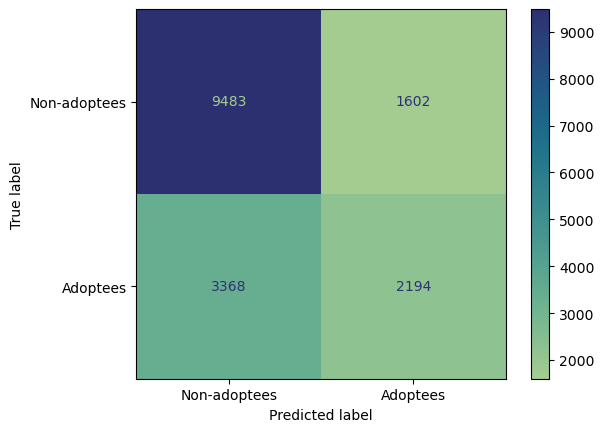

In [ ]:
# create the classifier
lr_clf = LogisticRegression() # adds L2 penalty by default
# fit the data
lr_clf.fit(X_train, y_train)

# find the predicted y from test data
y_test_pred =  lr_clf.predict(X_test)

# plot the confusion matrix
con_mat = confusion_matrix(y_test, y_test_pred)
# help displaying a confusion matrix with labels
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
labels = ['Non-adoptees', 'Adoptees']
cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
cmd.plot(cmap="crest")

# finding the different measurements
tn, fp, fn, tp = con_mat.ravel()

print(f"Accuracy: {round((tp + tn) / (tp + tn + fp + fn),3)}")
print(f"adoptee Precision: {round(tp / (tp + fp),3)}")
print(f"non_adoptee Precision: {round(tn / (tn + fn),3)}")
print(f"adoptee Recall: {round(tp / (tp + fn),3)}")
print(f"non_adoptee Recall: {round(tn / (tn + fp),3)}")
print(f"adoptee f1: {round(2 * ((tp / (tp + fp)) * (tp / (tp + fn))) / ((tp / (tp + fp) + tp / (tp + fn))), 3)}")
print(f"non_adoptee f1: {round(2 * ((tn / (tn + fn)) * (tn / (tn + fp))) / ((tn / (tn + fn)) + (tn / (tn + fp))), 3)}")

Let us now try to change the c value in the logistic regression model.

We see that decreasing the inverse regularization strength causes the model to increase the strength of the regularization term, thereby leading to less overfitting. However, we see that reducing C by this much has led to even worse model performance than leaving C = 1 (for adoptee posts recall and f1 are much worse)

Accuracy: 0.688
adoptee Precision: 0.747
non_adoptee Precision: 0.685
adoptee Recall: 0.1
non_adoptee Recall: 0.983
adoptee f1: 0.177
non_adoptee f1: 0.808


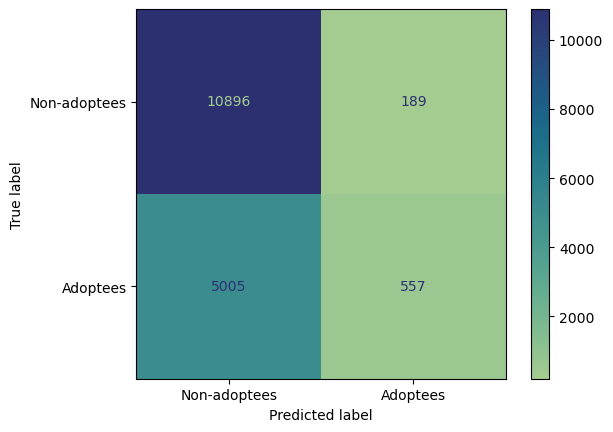

In [ ]:
# create the classifier
lr_clf = LogisticRegression(C=.001)
# fit the data
lr_clf.fit(X_train, y_train)

# find the predicted y from test data
y_test_pred =  lr_clf.predict(X_test)

# plot the confusion matrix
con_mat = confusion_matrix(y_test, y_test_pred)
# help displaying a confusion matrix with labels
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
labels = ['Non-adoptees', 'Adoptees']
cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
cmd.plot(cmap="crest")

# finding the different measurements
tn, fp, fn, tp = con_mat.ravel()

print(f"Accuracy: {round((tp + tn) / (tp + tn + fp + fn),3)}")
print(f"adoptee Precision: {round(tp / (tp + fp),3)}")
print(f"non_adoptee Precision: {round(tn / (tn + fn),3)}")
print(f"adoptee Recall: {round(tp / (tp + fn),3)}")
print(f"non_adoptee Recall: {round(tn / (tn + fp),3)}")
print(f"adoptee f1: {round(2 * ((tp / (tp + fp)) * (tp / (tp + fn))) / ((tp / (tp + fp) + tp / (tp + fn))), 3)}")
print(f"non_adoptee f1: {round(2 * ((tn / (tn + fn)) * (tn / (tn + fp))) / ((tn / (tn + fn)) + (tn / (tn + fp))), 3)}")

Let's try a model with both l1 and l2 penalties.


With both penalities the model performs still worse than the base model with an l2 regularization penalty. Though the accuracy is higher, recall and f1 is worse. This model is better than the model with  l2 and c = .001

Accuracy: 0.711
adoptee Precision: 0.664
non_adoptee Precision: 0.718
adoptee Recall: 0.271
non_adoptee Recall: 0.931
adoptee f1: 0.385
non_adoptee f1: 0.811


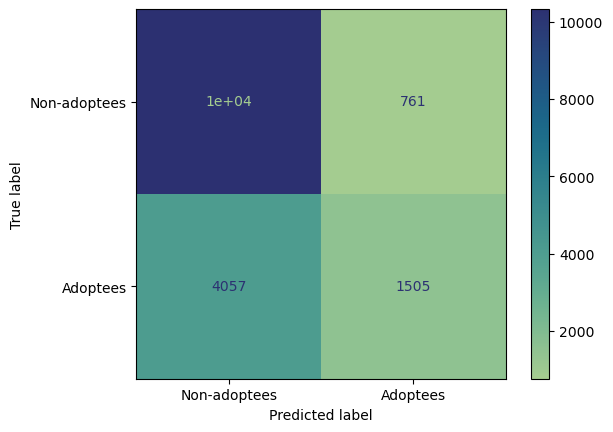

In [ ]:
# create the classifier
lr_clf = LogisticRegression(penalty="elasticnet", C=.1, solver="saga", l1_ratio=0.5 )
# fit the data
lr_clf.fit(X_train, y_train)

# find the predicted y from test data
y_test_pred =  lr_clf.predict(X_test)

# plot the confusion matrix
con_mat = confusion_matrix(y_test, y_test_pred)
# help displaying a confusion matrix with labels
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
labels = ['Non-adoptees', 'Adoptees']
cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
cmd.plot(cmap="crest")

# finding the different measurements
tn, fp, fn, tp = con_mat.ravel()

print(f"Accuracy: {round((tp + tn) / (tp + tn + fp + fn),3)}")
print(f"adoptee Precision: {round(tp / (tp + fp),3)}")
print(f"non_adoptee Precision: {round(tn / (tn + fn),3)}")
print(f"adoptee Recall: {round(tp / (tp + fn),3)}")
print(f"non_adoptee Recall: {round(tn / (tn + fp),3)}")
print(f"adoptee f1: {round(2 * ((tp / (tp + fp)) * (tp / (tp + fn))) / ((tp / (tp + fp) + tp / (tp + fn))), 3)}")
print(f"non_adoptee f1: {round(2 * ((tn / (tn + fn)) * (tn / (tn + fp))) / ((tn / (tn + fn)) + (tn / (tn + fp))), 3)}")

We see that there is not much improvement through tinkering with the hyperparameters for logistic regression. Let us now try a different vectorizer to see whether we get any improvement.

In [ ]:
summed_truth = truth_df['normalized_sents'].sum()

In [ ]:
# code from content analysis week4 hw
truth_w2v = gensim.models.word2vec.Word2Vec(summed_truth, sg=0)

In [ ]:
# save model
truth_w2v.wv.save("adopt_word2vec_new")

In [ ]:
# code aided by ChatGPT and content analysis hw4
X = []
for sentence in truth_df['normalized_tokens']:
    # create a list of word vectors for a given sentence
    vectors = []
    for word in sentence:
        # Check if the word is in the vocabulary of the Word2Vec model
        if word in truth_w2v.wv:
            vectors.append(truth_w2v.wv[word])
    if vectors:
        # Calculate the mean vector if at least one word is found in the vocabulary
        X.append(np.mean(vectors, axis=0))
    else:
        # for sentences with no words in vocabulary add an empty vector
        X.append(np.zeros(truth_w2v.vector_size))  # Use the vector size of the Word2Vec model

y = truth_df.labels

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We see that using a word2vec vectorizer, the model does not perform well.  Accuracy is 2/3 but the sample split is also 2/3 so this model is not good. Similar to the decision tree from the last project part, it labels almost all posts as non adoptee. Adoptee F1 and recall are extremely low.

Accuracy: 0.666
adoptee Precision: 0.458
non_adoptee Precision: 0.668
adoptee Recall: 0.01
non_adoptee Recall: 0.994
adoptee f1: 0.02
non_adoptee f1: 0.799


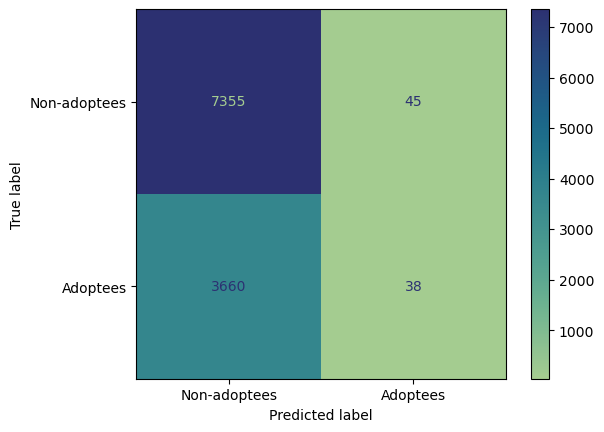

In [ ]:
lr_clf = LogisticRegression(C=.001) # adds L2 penalty by default
# fit the data
lr_clf.fit(X_train, y_train)

# find the predicted y from test data
y_test_pred =  lr_clf.predict(X_test)

# plot the confusion matrix
con_mat = confusion_matrix(y_test, y_test_pred)
# help displaying a confusion matrix with labels
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
labels = ['Non-adoptees', 'Adoptees']
cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
cmd.plot(cmap="crest")

# finding the different measurements
tn, fp, fn, tp = con_mat.ravel()

print(f"Accuracy: {round((tp + tn) / (tp + tn + fp + fn),3)}")
print(f"adoptee Precision: {round(tp / (tp + fp),3)}")
print(f"non_adoptee Precision: {round(tn / (tn + fn),3)}")
print(f"adoptee Recall: {round(tp / (tp + fn),3)}")
print(f"non_adoptee Recall: {round(tn / (tn + fp),3)}")
print(f"adoptee f1: {round(2 * ((tp / (tp + fp)) * (tp / (tp + fn))) / ((tp / (tp + fp) + tp / (tp + fn))), 3)}")
print(f"non_adoptee f1: {round(2 * ((tn / (tn + fn)) * (tn / (tn + fp))) / ((tn / (tn + fn)) + (tn / (tn + fp))), 3)}")

Overall, we see that the best model was the base logistic regression model (with l2 penalty already applied). We see that we can increase accuracy to around .711 but the con for using the model that takes into consideration l1 and l2 penalties is that adoptee recall and f1 score are reduced. Overall we note that accuracy here tells us very little in regards to how well the model performs given the uneven split of X and y training and testing data. We prioritize looking at other measures like recall, precision, and F1 to formulate which model fits the best. We see that logistic regression performs ever so slightly better than decision trees but not significantly. Our data, it seems, remains hard to classify using traditional machine learning classification methods.